# Model Building

In this notebook, I will create, train and perform hyper-parameter tuning on three different classifiers. The goal is to reach highest possible accuracy on test data.

The Classification algorithms used are:

1. XGBoost - Xtreme Gradient Boosting
2. CatBoost
3. Random Forest Classifier

All the classifier will use sklearn implementation for training and CVSearch.

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import os

#Reading Extracted Festures
path = os.path.join('Training_Features', 'Splitted_Dataset_Features_3sec.csv')
df = pd.read_csv(path)
df.head(5)

,File_Name,Tempo,Label,Chroma_STFT_Mean,Chroma_STFT_Var,RMS_Mean,RMS_Var,Spectral_Centroid_Mean,Spectral_Centroid_Var,Spectral_Bandwidth_Mean,...,MFCC16_Mean,MFCC16_Var,MFCC17_Mean,MFCC17_Var,MFCC18_Mean,MFCC18_Var,MFCC19_Mean,MFCC19_Var,MFCC20_Mean,MFCC20_Var
0,blues.00000.0,129.199219,blues,0.335434,0.091088,0.130405,0.003521,1773.285877,168244.72840,1972.723622,...,-2.849641,39.725563,-3.241225,36.486427,0.721986,38.096760,-5.043307,33.608330,-0.237658,43.827770
1,blues.00000.1,123.046875,blues,0.343020,0.086142,0.112699,0.001450,1816.195860,90703.32519,2009.201575,...,4.123801,65.312965,-6.100084,40.738820,0.219240,50.587795,-2.875456,96.975440,5.800726,60.006115
2,blues.00000.2,123.046875,blues,0.346838,0.092210,0.132002,0.004620,1788.642783,111322.53710,2085.045996,...,4.789981,67.582200,-1.801321,28.132212,2.308315,48.102486,-1.931482,53.116814,2.522431,33.136240
3,blues.00000.3,123.046875,blues,0.363671,0.086856,0.132562,0.002447,1654.902168,112316.26440,1959.202709,...,-1.322859,47.059677,-3.859235,27.984930,1.255384,35.093280,-3.619866,51.420635,3.639336,31.930040
4,blues.00000.4,123.046875,blues,0.335927,0.088291,0.143289,0.001701,1630.737017,79648.22830,1948.459295,...,2.090514,30.307617,0.629567,44.883636,1.709781,51.706690,-3.402106,26.686306,0.546950,29.212286


## Encoding Target Labels

In [2]:
#Encoder
label_enc = {}
for i, label in enumerate(df.Label.unique()):
  label_enc[label] = i

label_enc

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [3]:
#Shuffling and encoding
df.Label = df.Label.apply(lambda label : label_enc[label])
df = df.sample(frac=1).reset_index(drop=True)

#Checking
df.head(10)[['File_Name','Label']]

,File_Name,Label
0,classical.00046.3,1
1,metal.00057.0,6
2,reggae.00007.7,8
3,country.00050.1,2
4,country.00046.6,2
5,reggae.00050.5,8
6,reggae.00019.5,8
7,classical.00082.4,1
8,hiphop.00086.0,4
9,reggae.00066.5,8


## Train, Test Split

For training 70% of the data will be used and subsequently 30% of the data will be utilized for testing

In [4]:
# Seperating Features and Labels
df_X = df.drop(columns = ['File_Name', 'Label'])
df_y = df.pop('Label')

#Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

#Checking Number of instances
print('Number of instances in training set : {}, {:.1f}%'.format(X_train.shape[0], (X_train.shape[0]/9981)*100))
print('Number of instances in testing set : {}, {:.1f}%'.format(X_test.shape[0], (X_test.shape[0]/9981)*100))

Number of instances in training set : 6986, 70.0%
Number of instances in testing set : 2995, 30.0%


## Feature Scaling

Different features are on different scales and since classification algorithms are sensitive to scaling of the data, I am Standardizing all of the features while preventing any data leakage.

In [5]:
from sklearn.preprocessing import StandardScaler

cols = X_train.columns
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns = cols)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.head()

,Tempo,Chroma_STFT_Mean,Chroma_STFT_Var,RMS_Mean,RMS_Var,Spectral_Centroid_Mean,Spectral_Centroid_Var,Spectral_Bandwidth_Mean,Spectral_Bandwidth_Var,Spectral_Rolloff_Mean,...,MFCC16_Mean,MFCC16_Var,MFCC17_Mean,MFCC17_Var,MFCC18_Mean,MFCC18_Var,MFCC19_Mean,MFCC19_Var,MFCC20_Mean,MFCC20_Var
0,0.139939,1.425623,-0.278757,1.072605,2.186911,1.556728,2.656442,1.886438,0.727727,1.759799,...,0.415780,0.316748,-0.057151,0.028070,-0.309088,-0.029330,1.621807,0.031028,0.025329,-0.715449
1,-0.047183,-0.476646,0.350565,0.189832,-0.273210,-0.760951,-0.778536,-0.539592,-0.572352,-0.670467,...,0.113761,-0.566708,0.844671,-0.199316,0.184403,-0.029209,-0.185281,-0.690624,0.282688,-0.613597
2,-0.982794,0.504151,-0.119724,0.049238,-0.430682,0.308479,1.526889,0.698438,2.656525,0.130519,...,-0.495328,0.738669,1.962506,-0.073803,0.025118,3.029950,1.210295,-0.317640,-0.274510,0.051418
3,-0.047183,0.041636,0.732934,-0.149228,0.245576,-0.565436,-0.349453,-0.554438,0.288149,-0.466515,...,-0.522837,0.251242,-0.447743,0.791174,0.691446,2.204526,0.170457,-0.444649,-0.495398,-0.058196
4,-0.217294,0.743883,0.593781,0.090314,0.637729,-0.204684,0.297451,0.597283,1.112304,0.008594,...,-0.900874,-0.757234,-0.077248,-0.639338,0.568159,-0.396001,-0.221948,-0.428561,-0.387130,-0.739125


## Helper Function

A function to quickly validate the model by plotting the confusion matrix and printing the classification report.

Can be used either with training data or test data

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#Function definition
def model_report(clf, test_data=False, conf_matrix=True, class_report=True):
  X, y = X_train, y_train
  if test_data:
    X, y = X_test, y_test
  y_preds = clf.predict(X)

  #Plotting Confusion Matrix 
  if conf_matrix:
    fig = plt.figure(figsize=(8,12))
    ConfusionMatrixDisplay.from_predictions(y, y_preds, display_labels=label_enc.keys(), cmap='BuPu', 
                                            ax=plt.gca(), colorbar=False, xticks_rotation=90)

    plt.tick_params(axis='both', pad=4, labelsize='large')
    plt.title('Confusion Matrix for {}'.format(str(type(clf)).split('.')[-1][:-2]), 
              fontsize=15)
    plt.ylabel('True Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.show()
    print('\n\n')
  
  #Classification report
  if class_report:
    if test_data: print('Test Data Report:\n')
    else: print('Train Data Report:\n') 
    print(classification_report(y, y_preds, digits=3))
    print('='*60)
  
  return fig

## 1. XGBoost - Extreme Gradient Boosting

In [7]:
import xgboost as xgb
print(xgb.__version__)

1.6.0


### Parameter Grid for Hyper-Parameter Tuning

In [8]:
#Initiation
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

#Parameter Grid
from scipy.stats import uniform, randint
xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
  }

### Hyper-Parameter Tuning

I am Utilizing Random Search for tuning the models since a random search can potentialy reach the best parameters faster then simple Grid Search

In [9]:
#Hyper parameter Tuning
from sklearn.model_selection import RandomizedSearchCV

#Radomized Search
xgb_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params,
                                n_iter=30, cv = 3, verbose=2, n_jobs = -1, random_state=42, 
                                scoring='f1_weighted', return_train_score=True)

xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd5869ebb50>,
         

In [10]:
#Displaying the best parameter found by the random search
print(xgb_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7467983561008608, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.02904180608409973, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.28985284373248055, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=139, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42,
              reg_alpha=0, ...)


### XGBoost Model Report

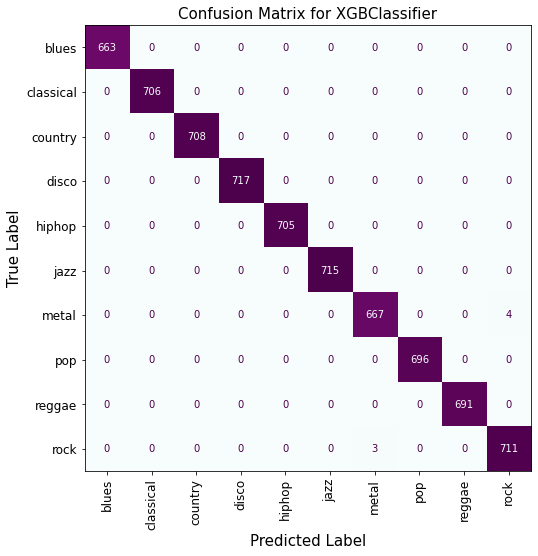




Train Data Report:

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       663
           1      1.000     1.000     1.000       706
           2      1.000     1.000     1.000       708
           3      1.000     1.000     1.000       717
           4      1.000     1.000     1.000       705
           5      1.000     1.000     1.000       715
           6      0.996     0.994     0.995       671
           7      1.000     1.000     1.000       696
           8      1.000     1.000     1.000       691
           9      0.994     0.996     0.995       714

    accuracy                          0.999      6986
   macro avg      0.999     0.999     0.999      6986
weighted avg      0.999     0.999     0.999      6986



In [11]:
#On Training Data
fig = model_report(xgb_search.best_estimator_, test_data=False)

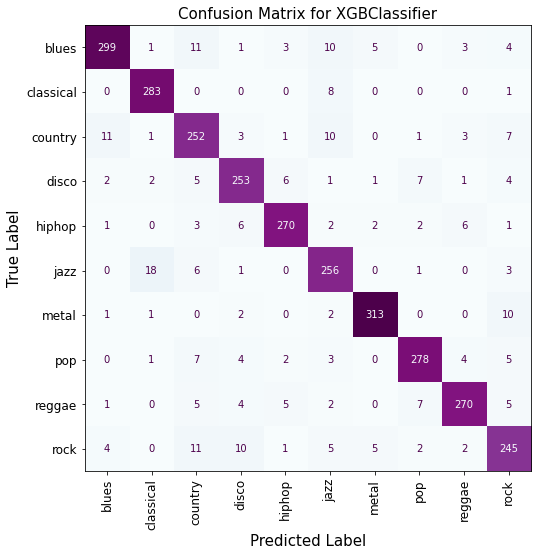




Test Data Report:

              precision    recall  f1-score   support

           0      0.937     0.887     0.912       337
           1      0.922     0.969     0.945       292
           2      0.840     0.872     0.856       289
           3      0.891     0.897     0.894       282
           4      0.938     0.922     0.929       293
           5      0.856     0.898     0.877       285
           6      0.960     0.951     0.956       329
           7      0.933     0.914     0.924       304
           8      0.934     0.903     0.918       299
           9      0.860     0.860     0.860       285

    accuracy                          0.908      2995
   macro avg      0.907     0.907     0.907      2995
weighted avg      0.909     0.908     0.908      2995



In [12]:
#On Test Data
fig = model_report(xgb_search.best_estimator_, test_data=True)

#Saving
path = os.path.join('Visualization', 'XGB_Confusion_Matrix.png')
fig.savefig(path, bbox_inches='tight', dpi=250);

#### **Remarks**

The XGB Model achieved an accuracy of 99% and 90.8% on Training and Testing Data Respectively.

The Model is overfitting a little but that can be easily rectified at the later stage of ensembling.

In [13]:
#Saving Model as json(Better saving option)
path = os.path.join('Saved_Models', 'XGBClassifier.json')
xgb_search.best_estimator_.save_model(path)

#Saving as native python code(Only predication capable for deployment)
import m2cgen as m2c
xgbc_native = m2c.export_to_python(xgb_search.best_estimator_)

path = os.path.join('Saved_Models', 'XGBCNative.py')
with open(path, 'w') as f:
  f.write(xgbc_native)

## 2. CatBoost

In [14]:
#Initiation
import catboost as cb
cbc = cb.CatBoostClassifier(random_state=42, verbose=False, eval_metric='TotalF1', loss_function='MultiClass')

### Parameter Grid for Hyper-Parameter Tuning

In [15]:
grid = {'learning_rate': uniform(0.03, 0.3),
        'depth': randint(2, 6),
        'l2_leaf_reg': uniform(1,9)}

### Hyper-Parameter Tuning

In [16]:
cbc_search = cbc.randomized_search(param_distributions=grid, X = X_train, y= y_train, cv=3,
                  n_iter=30, partition_random_seed=42, calc_cv_statistics=True, verbose=False)  


bestTest = 0.8510920358
bestIteration = 927


bestTest = 0.8097016229
bestIteration = 985


bestTest = 0.8578085917
bestIteration = 958


bestTest = 0.8527539231
bestIteration = 769


bestTest = 0.8155994271
bestIteration = 994


bestTest = 0.8214479802
bestIteration = 995


bestTest = 0.8542542074
bestIteration = 989


bestTest = 0.7884677247
bestIteration = 998


bestTest = 0.837469691
bestIteration = 990


bestTest = 0.762874933
bestIteration = 997


bestTest = 0.8640539166
bestIteration = 998


bestTest = 0.8684989576
bestIteration = 887


bestTest = 0.8525788914
bestIteration = 998


bestTest = 0.8700215882
bestIteration = 917


bestTest = 0.7797647321
bestIteration = 968


bestTest = 0.8286173773
bestIteration = 983


bestTest = 0.8690232315
bestIteration = 983


bestTest = 0.7820296501
bestIteration = 981


bestTest = 0.7771327665
bestIteration = 985


bestTest = 0.8146310679
bestIteration = 982


bestTest = 0.8223884462
bestIteration = 967


bestTest = 0.8206614947
bestIterati

### CatBoost Model Report

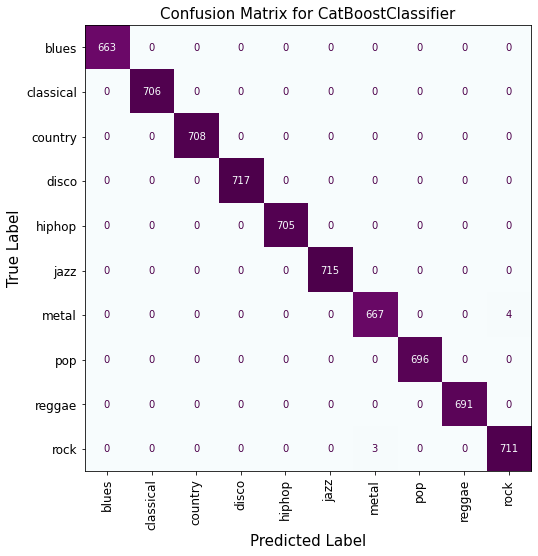




Train Data Report:

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       663
           1      1.000     1.000     1.000       706
           2      1.000     1.000     1.000       708
           3      1.000     1.000     1.000       717
           4      1.000     1.000     1.000       705
           5      1.000     1.000     1.000       715
           6      0.996     0.994     0.995       671
           7      1.000     1.000     1.000       696
           8      1.000     1.000     1.000       691
           9      0.994     0.996     0.995       714

    accuracy                          0.999      6986
   macro avg      0.999     0.999     0.999      6986
weighted avg      0.999     0.999     0.999      6986



In [17]:
#On Training Data
fig = model_report(cbc, test_data=False)

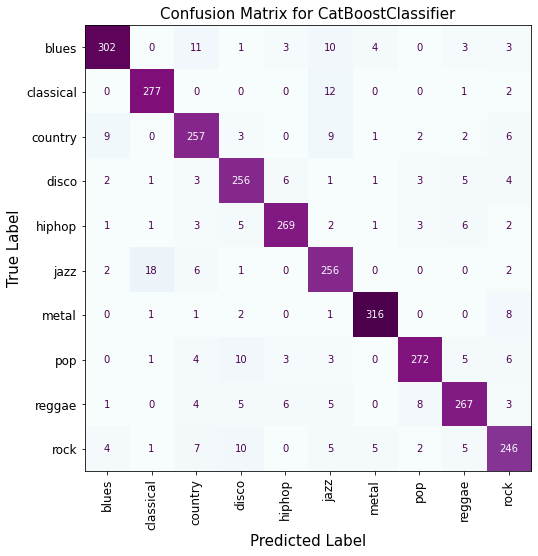




Test Data Report:

              precision    recall  f1-score   support

           0      0.941     0.896     0.918       337
           1      0.923     0.949     0.936       292
           2      0.868     0.889     0.879       289
           3      0.874     0.908     0.890       282
           4      0.937     0.918     0.928       293
           5      0.842     0.898     0.869       285
           6      0.963     0.960     0.962       329
           7      0.938     0.895     0.916       304
           8      0.908     0.893     0.901       299
           9      0.872     0.863     0.868       285

    accuracy                          0.908      2995
   macro avg      0.907     0.907     0.907      2995
weighted avg      0.908     0.908     0.908      2995



In [18]:
#On Testing Data
fig = model_report(cbc, test_data=True)

#Saving
path = os.path.join('Visualization', 'CB_Confusion_Matrix.png')
fig.savefig(path, bbox_inches='tight', dpi=250)

#### **Remarks**

The CatBoost Model achieved an accuracy of 99% and 90.8% on Training and Testing Data Respectively.

Catboost is also mildly overfitting, but gave better results than xgboost for this dataset.

In [19]:
#Saving catboost model
path = os.path.join('Saved_Models', 'CBClassifier.json')
cbc.save_model(path)

##3.  Random Forest Classifier

In [20]:
#Initiation
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

### Parameter Grid

In [21]:
grid = {'n_estimators' : randint(50,120),
        'max_depth' : randint(5,20),
        'min_samples_split' : randint(5,20),
        'min_samples_leaf' : randint(1,8)}

### Hyper-Parameter Tuning

In [22]:
rfc_search =  RandomizedSearchCV(estimator=rfc, param_distributions=grid,
                                n_iter=30, cv = 5, verbose=2, n_jobs = -1, random_state=42, 
                                scoring='f1_weighted', return_train_score=True)
rfc_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd57773abd0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd577741d90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd577741990>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd577741890>},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=2)

In [23]:
#Displaying the best parameter found by the radnom search
rfc_search.best_estimator_

RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=98, n_jobs=-1, random_state=42)

### Random Forest Model Report

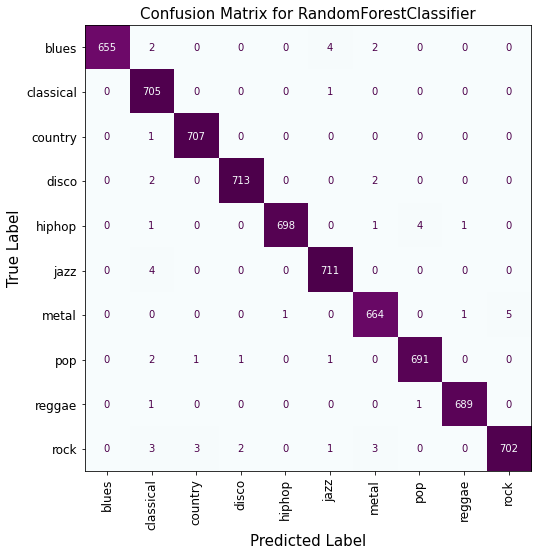




Train Data Report:

              precision    recall  f1-score   support

           0      1.000     0.988     0.994       663
           1      0.978     0.999     0.988       706
           2      0.994     0.999     0.996       708
           3      0.996     0.994     0.995       717
           4      0.999     0.990     0.994       705
           5      0.990     0.994     0.992       715
           6      0.988     0.990     0.989       671
           7      0.993     0.993     0.993       696
           8      0.997     0.997     0.997       691
           9      0.993     0.983     0.988       714

    accuracy                          0.993      6986
   macro avg      0.993     0.993     0.993      6986
weighted avg      0.993     0.993     0.993      6986



In [24]:
#On Training Data
fig = model_report(rfc_search.best_estimator_, test_data=False)

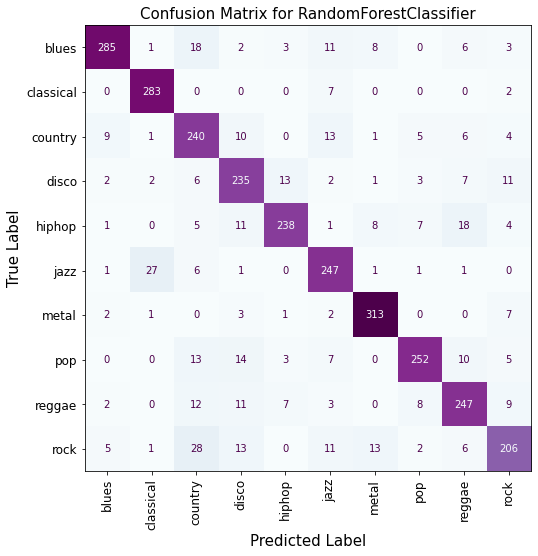




Test Data Report:

              precision    recall  f1-score   support

           0      0.928     0.846     0.885       337
           1      0.896     0.969     0.931       292
           2      0.732     0.830     0.778       289
           3      0.783     0.833     0.808       282
           4      0.898     0.812     0.853       293
           5      0.812     0.867     0.839       285
           6      0.907     0.951     0.929       329
           7      0.906     0.829     0.866       304
           8      0.821     0.826     0.823       299
           9      0.821     0.723     0.769       285

    accuracy                          0.850      2995
   macro avg      0.850     0.849     0.848      2995
weighted avg      0.853     0.850     0.850      2995



In [25]:
#On Testing Data
fig = model_report(rfc_search.best_estimator_, test_data=True)

#Saving
path = os.path.join('Visualization', 'RF_Confusion_Matrix.png')
fig.savefig(path, bbox_inches='tight', dpi=250)

#### **Remarks**

The Random Forest Model achieved an accuracy of 99% and 85% on Training and Testing Data Respectively.

By far the weakest learner but could potentially imporve the ensembled model characteristic

In [26]:
#Saving Random Forest Model
import joblib
path = os.path.join('Saved_Models', 'RFClassifier.sav')
with open(path, 'wb') as f:
  joblib.dump(rfc_search.best_estimator_, f,compress=3)

#Saving as native python code(Only prediction capable for deployment)
import m2cgen as m2c
rfc_native = m2c.export_to_python(rfc_search.best_estimator_)

path = os.path.join('Saved_Models', 'RFCNative.py')
with open(path, 'w') as f:
  f.write(rfc_native)